In [1]:
# !pip install kagglehub
import kagglehub
import pandas as pd
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


np.set_printoptions(suppress=True)
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")


dataset_path = f"{path}/diabetes_binary_health_indicators_BRFSS2015.csv"
data = pd.read_csv(dataset_path)
print(data.head())



   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0   

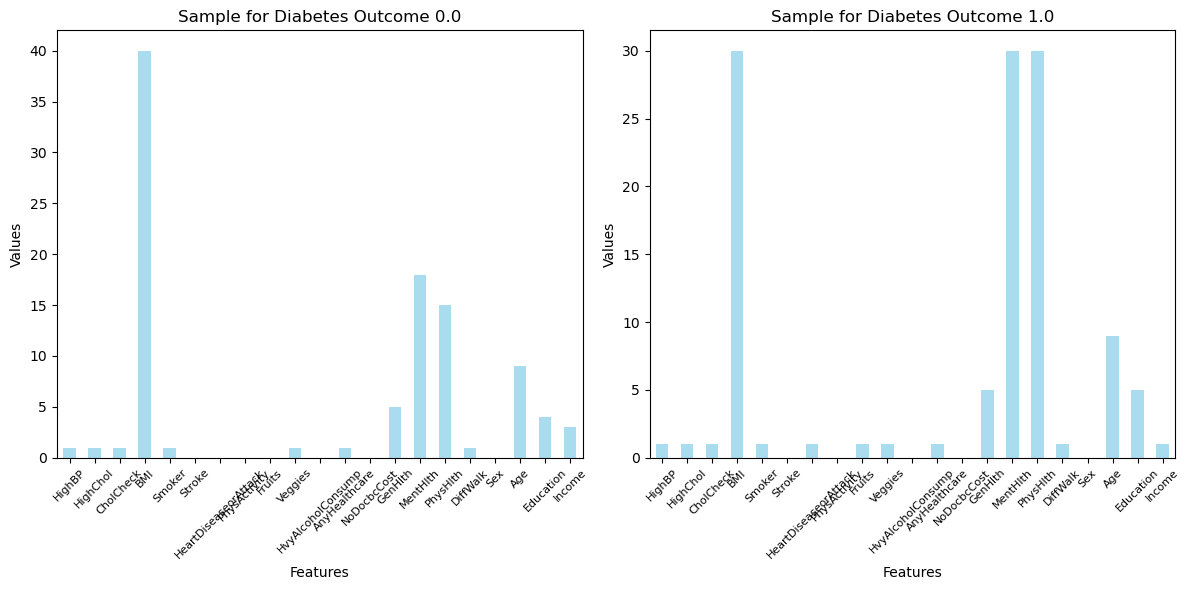

In [2]:
#Visualizations
samples = {}
for label in data['Diabetes_binary'].unique():
    # Store the first example for each outcome
    samples[label] = data[data['Diabetes_binary'] == label].iloc[0]

# Create subplots
plt.figure(figsize=(12, 6))
for i, label in enumerate(sorted(samples.keys())):
    plt.subplot(1, 2, i + 1)
    sample = samples[label].drop('Diabetes_binary')  # Drop the label for clarity
    sample.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f"Sample for Diabetes Outcome {label}")
    plt.xticks(rotation=45, fontsize=8)
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.tight_layout()

plt.show()

In [3]:
#Data Preprocessing and Data Splitting 
X = data.drop(columns=['Diabetes_binary']).values  # Features
y = data['Diabetes_binary'].values  # Labels

# Function to split data
def get_train_valid_test_data(X: np.ndarray, y: np.ndarray):
    """
    Randomizes and splits the data into train, validation, and test sets.

    Args:
        X: Data given as a 2D matrix
        y: Labels given as a vector
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=0.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=0.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from typing import Tuple

def add_bias(X: np.ndarray) -> np.ndarray:
    """
    Adds a bias term (a column of ones) to the dataset.
    
    Args:
        X: A 2D NumPy array of features.

    Returns:
        A new NumPy array with an additional column of ones.
    """
    return np.hstack((np.ones((X.shape[0], 1)), X))


def get_preprocessed_data() -> Tuple[np.ndarray]:
    """
    Gets preprocessed data for training, validation, and testing.

    Return:
        A tuple of NumPy arrays where indices 0-1 
        contain the training data/targets, indices 2-3
        contain the validation data/targets, and 4-5
        contain the testing data/targets.
    """
    # Load diabetes dataset
    file_path = f"{path}/diabetes_binary_health_indicators_BRFSS2015.csv"
    data = pd.read_csv(file_path)

    X, y = data.drop(columns=['Diabetes_binary']).values, data['Diabetes_binary'].values

    encoder = OneHotEncoder(sparse_output=False)
    y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

    # Spliting the data 
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    # Add bias term to features
    X_trn = add_bias(X_trn)
    X_vld = add_bias(X_vld)
    X_tst = add_bias(X_tst)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst


In [5]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_decision_boundary(
    model: object, 
    X: np.ndarray, 
    y: np.ndarray,
    xlabel: str = '',
    ylabel: str = '',
    class_names: Dict[int, str] = None
) -> None:
    """
    Plots the decision boundary for data with 2 features.

    Args:
        model: Trained classifier with a predict method.
        X: Data to be plotted (2D).
        y: Labels for corresponding data.
        xlabel: X-axis label for plot.
        ylabel: Y-axis label for plot.
        class_names: Dictionary mapping labels to class names.
    """
    assert X.shape[-1] == 2, f"`X` must have 2 features, not {X.shape[-1]}"
    
    if class_names is None:
        class_names = {}

    buffer = 0.5
    x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer
    y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    fake_data = np.c_[xx.ravel(), yy.ravel()]
    
    fake_data = np.hstack([np.ones((fake_data.shape[0], 1)), fake_data])

    y_hat = model.predict(fake_data)

    plt.contourf(xx, yy, y_hat.reshape(xx.shape), alpha=0.8, cmap=plt.cm.RdYlBu)

    labels = np.unique(y)
    for l in labels:
        class_locs = np.where(y == l)[0]
        class_name = class_names.get(l, f'class {l}')
        plt.scatter(X[class_locs, 0], X[class_locs, 1], label=class_name, edgecolor='k')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title("Decision Boundary")
    plt.show()

In [7]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_names: Dictionary mapping labels to class names.

                Example: {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() 
    y_hat = y_hat.flatten() 
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True, fmt='g')
    plt.show()
    return cfm_df

In [8]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    # TODO 4
    
    return (np.exp(z)) / ((1 + np.exp(z)))

In [9]:
def softmax(z: np.ndarray) -> np.ndarray:
    """ Computes the stablized version of the softmax

        Args:
            z: A vector or matrix of continuous values.

        Return:
            A NumPy array with the same shape as the input.
    """
    # TODO 5
    return np.exp(z - np.max(z, axis=1, keepdims=True)) / np.sum(np.exp(z - np.max(z, axis=1, keepdims=True)), axis=1, keepdims=True)

In [10]:
def nll_loss(y: np.ndarray, probs: np.ndarray) -> float:
    """ Computes the average generalized NLL Loss

        Args:
            y: The ground truth one-hot encoded labels
                given as matrix of shape (M, |K|).

            probs: The predicted probabilities for the
                corresponding labels given as a matrix
                of shape (M, |K|)
    """
    # TODO 6
    return (-1 / y.shape[0]) * np.sum(y * np.log(probs))

In [11]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [12]:
def TEST_softmax_vector():
    rng = np.random.RandomState(0)
    z = rng.rand(1, 3)
    print(f"z shape: {z.shape}")
    print(f"z:\n{z}\n")

    probs = softmax(z)
    print(f"probs shape: {probs.shape}")
    print(f"probs:\n{probs}\n")
    
TEST_softmax_vector()

z shape: (1, 3)
z:
[[0.5488135  0.71518937 0.60276338]]

probs shape: (1, 3)
probs:
[[0.30898065 0.36491138 0.32610797]]



Accuracy: 0.8626651473622617


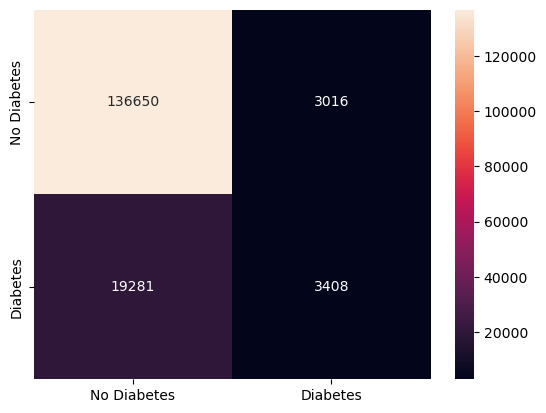

,No Diabetes,Diabetes
No Diabetes,136650,3016
Diabetes,19281,3408


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

class SoftmaxRegression:
    def __init__(self, alpha=0.01, batch_size=32, epochs=100, seed=None):
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.W = None
        self.trn_loss = []
        self.vld_loss = []

    def fit(self, X_trn, y_trn, X_vld, y_vld):
        if self.seed is not None:
            np.random.seed(self.seed)

        n_features = X_trn.shape[1]
        n_classes = y_trn.shape[1]
        self.W = np.random.randn(n_features, n_classes)

        for epoch in range(self.epochs):
            batches = get_batches(data_len=X_trn.shape[0], batch_size=self.batch_size)
            epoch_loss = 0

            for batch in batches:
                X_batch = X_trn[batch]
                y_batch = y_trn[batch]

                probs = softmax(X_batch @ self.W)

                loss = nll_loss(y_batch, probs)
                epoch_loss += loss

                gradient = -X_batch.T @ (y_batch - probs) / X_batch.shape[0]

                self.W -= self.alpha * gradient

            self.trn_loss.append(epoch_loss / len(batches))

            val_probs = softmax(X_vld @ self.W)
            val_loss = nll_loss(y_vld, val_probs)
            self.vld_loss.append(val_loss)

    def predict(self, X):
        return np.argmax(softmax(X @ self.W), axis=1)

# Train the model
smr = SoftmaxRegression(
    alpha=0.001,
    batch_size=32,
    epochs=51,
    seed=0
)

smr.fit(X_trn, y_trn, X_vld, y_vld)

# Predict on training data
y_hat_trn = smr.predict(X_trn)

# Compute accuracy
accuracy = accuracy_score(y_true=np.argmax(y_trn, axis=1), y_pred=y_hat_trn)
print('Accuracy:', accuracy)

# Plot confusion matrix
plot_confusion_matrix(y=np.argmax(y_trn, axis=1), y_hat=y_hat_trn, class_names={0: 'No Diabetes', 1: 'Diabetes'})


Training Accuracy: 86.27%
Validation Accuracy: 86.51%


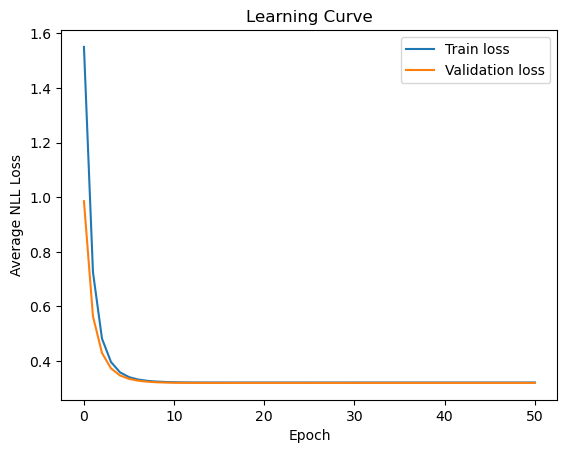

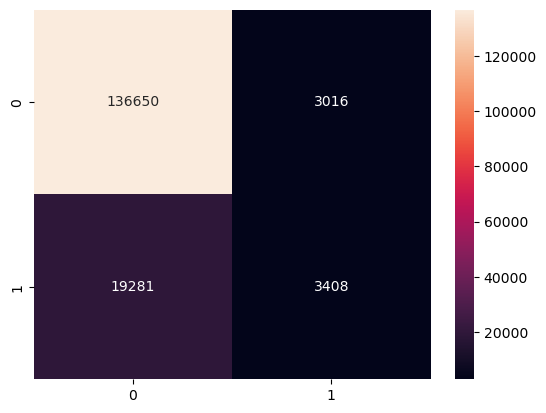

,0,1
0,136650,3016
1,19281,3408


In [14]:
#### TODO 8: Training Code
smr = SoftmaxRegression(alpha=0.001, batch_size=32, epochs=51, seed=0)
smr.fit(X_trn, y_trn, X_vld, y_vld)

y_hat_trn = smr.predict(X_trn)
y_hat_vld = smr.predict(X_vld)

train_accuracy = accuracy_score(y_true=np.argmax(y_trn, axis=1), y_pred=y_hat_trn)
val_accuracy = accuracy_score(y_true=np.argmax(y_vld, axis=1), y_pred=y_hat_vld)

# Print accuracies
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot the learning curve
plt.plot(smr.trn_loss, label='Train loss')
plt.plot(smr.vld_loss, label='Validation loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


plot_confusion_matrix(y=np.argmax(y_trn, axis=1), y_hat=y_hat_trn)

Test Accuracy: 86.61%


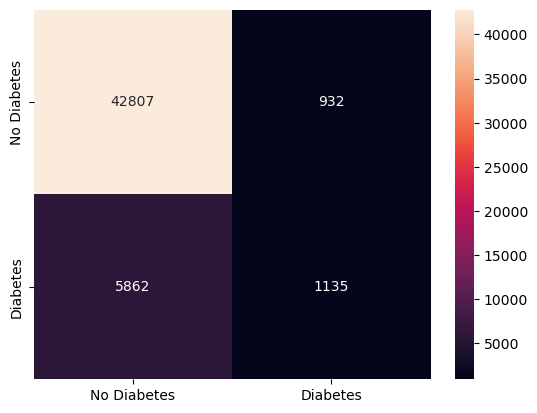

In [15]:
# TODO 8: Testing Code
y_pred_test = smr.predict(X_tst)

# Compute test accuracy
test_accuracy = np.mean(y_pred_test == np.argmax(y_tst, axis=1))

# Print test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot confusion matrix for test set predictions
plot_confusion_matrix(
    y=np.argmax(y_tst, axis=1), 
    y_hat=y_pred_test, 
    class_names={0: 'No Diabetes', 1: 'Diabetes'}
)
plt.show()


In [16]:
# START OF THE KNN NEXT NEAREST NEIGHBOR

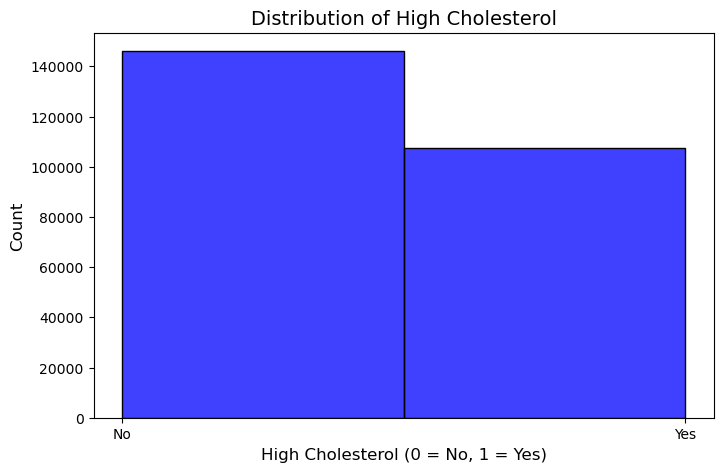

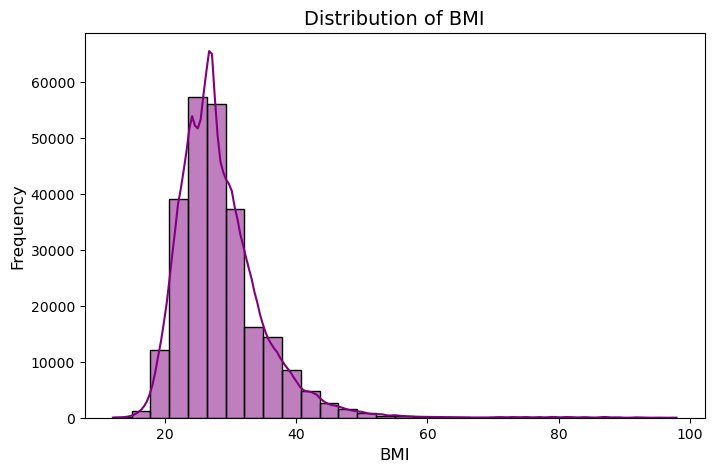

/var/folders/sq/llkyz7nd7gzg6p11s3b_chpm0000gn/T/ipykernel_93801/1640249601.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Diabetes_binary', y='HighChol', data=data, palette="viridis")


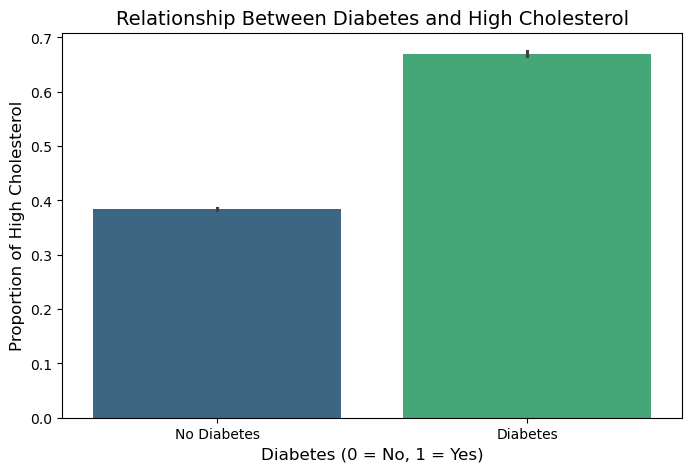

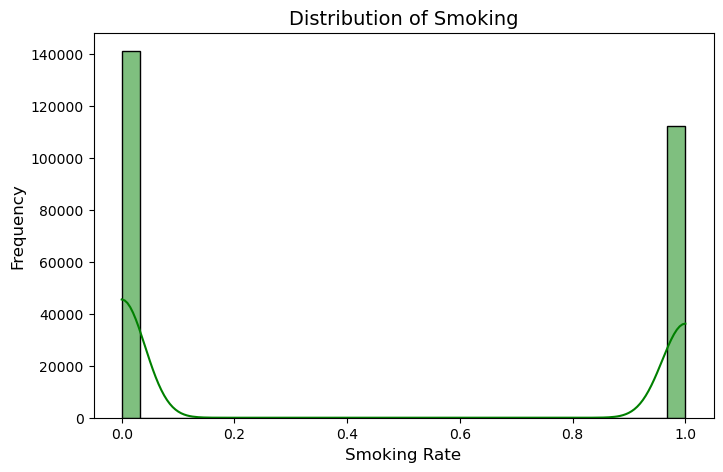

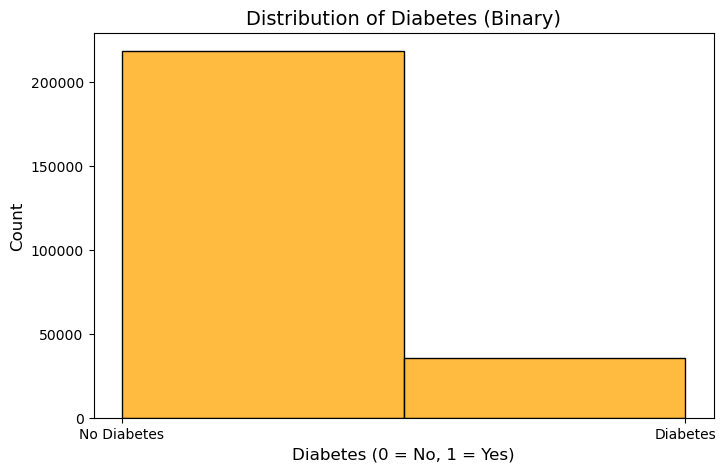

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import kagglehub



# Load your diabetes dataset
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
file_path = f"{path}/diabetes_binary_health_indicators_BRFSS2015.csv"  # Replace with the correct path
diabetes_data = pd.read_csv(file_path)


# Plot Smoking and Diabetes Distributions
def plot_smoking_diabetes(data):
    """
    Plots the distribution of Smoker and Diabetes_binary rates.
    """
    # Smoking distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data['Smoker'], kde=True, bins=30, color='green')
    plt.title("Distribution of Smoking", fontsize=14)
    plt.xlabel("Diabetes (0 = No, 1 = Yes)", fontsize=12)
    plt.xlabel("Smoking Rate", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

    # Diabetes distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data['Diabetes_binary'], kde=False, bins=2, color='orange')
    plt.title("Distribution of Diabetes (Binary)", fontsize=14)
    plt.xlabel("Diabetes (0 = No, 1 = Yes)", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(ticks=[0, 1], labels=["No Diabetes", "Diabetes"])
    plt.show()
#High Cholesterol and Diabetes Distributions
def plot_high_chol_bmi_diabetes(data):
    """
    Plots the distribution of High Cholesterol, BMI, and Diabetes_binary rates.
    """
    # High Cholesterol distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data['HighChol'], kde=False, bins=2, color='blue')
    plt.title("Distribution of High Cholesterol", fontsize=14)
    plt.xlabel("High Cholesterol (0 = No, 1 = Yes)", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
    plt.show()

    # BMI distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data['BMI'], kde=True, bins=30, color='purple')
    plt.title("Distribution of BMI", fontsize=14)
    plt.xlabel("BMI", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

    # Diabetes and High Cholesterol Relationship
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Diabetes_binary', y='HighChol', data=data, palette="viridis")
    plt.title("Relationship Between Diabetes and High Cholesterol", fontsize=14)
    plt.xlabel("Diabetes (0 = No, 1 = Yes)", fontsize=12)
    plt.ylabel("Proportion of High Cholesterol", fontsize=12)
    plt.xticks(ticks=[0, 1], labels=["No Diabetes", "Diabetes"])
    plt.show()

# Create Visualizations for High Cholesterol, BMI, and Diabetes
plot_high_chol_bmi_diabetes(diabetes_data)

# Create Visualizations for Smoking and Diabetes
plot_smoking_diabetes(diabetes_data)




In [18]:
def euclidean_distance(x: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """ Compute the euclidean distance between a row vectors or a vecotr and a matrix.
        Args:
            x: The 1st NumPy array given as a 1D vector or 2D row vector

            Y: The 2nd NumPy array given as a 2D row vector or 2D matrix

        Return:
            A 1D vector of flaots representing the distance between x and Y
    """
    assert len(Y.shape) == 2, f"y is a 1D vector, expected 2D row vector or matrix"
    # TODO 6
    distances = np.sqrt(np.sum((Y - x)**2, axis=1))

    return distances

In [19]:
class KNearestNeighbors():
    """
        Attributes:
            k: Number of nearest neighbors

            distance_measure: A python function reference which will compute a valid distance measure

            X: The training input features

            y: The training targets/labels
    """
    def __init__(self, k: int, distance_measure: Callable):
        """
            Args:
                k: Number of nearest neighbors

                distance_measure: A python function that computes a distance measure
        """
        self.k = k
        self.distance_measure = distance_measure
        self.X: np.ndarray = None
        self.y: np.ndarray = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """ Stores the training data for comparison 

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 1D vector
        """
        # TODO 8.1
        self.X = X
        self.y = y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Performs KNN using stored training data.
    
        Args:
            X: Testing data given as a 2D matrix.
    
        Return:
            Returns a 1D vector of predictions for each data sample in X.
        """
        y_hats = []
        for x in X:
            distances = self.distance_measure(x, self.X)
    
            k_indices = np.argsort(distances)[:self.k]
    
            k_nearest_labels = self.y[k_indices]
    
            k_nearest_labels = np.array(k_nearest_labels, dtype=int)
    
            label_counts = np.bincount(k_nearest_labels)
    
            y_hat = np.argmax(label_counts)
            y_hats.append(y_hat)
    
        return np.array(y_hats)


In [20]:
y_trn = np.argmax(y_trn, axis=1)
y_tst = np.argmax(y_tst, axis=1)

knn = KNearestNeighbors(k=3, distance_measure=euclidean_distance)

knn.fit(X_trn, y_trn)

y_hat = knn.predict(X_tst)

print(f"Predictions: {y_hat}")

test_acc = accuracy_score(y_true=y_tst, y_pred=y_hat)
print(f"Test accuracy: {test_acc:.2f}")


Predictions: [0 0 0 ... 0 0 0]
Test accuracy: 0.84


In [ ]:
from sklearn.metrics import accuracy_score

k_values = [1, 25, 50, 100]

for k in k_values:
    print(f"\nRunning KNN with k={k}")
    
    knn = KNearestNeighbors(k=k, distance_measure=euclidean_distance)
    
    knn.fit(X_trn, y_trn)
    
    y_hat = knn.predict(X_tst)
    print(f"Predictions with k={k}: {y_hat}")
    
    test_acc = accuracy_score(y_true=y_tst, y_pred=y_hat)
    print(f"Test accuracy with k={k}: {test_acc:.2f}")



Running KNN with k=1
Predictions with k=1: [0 0 0 ... 0 0 0]
Test accuracy with k=1: 0.80

Running KNN with k=25
